In [62]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
from numpy.linalg import svd, norm, pinv
import scipy.sparse.linalg as sp
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
%matplotlib inline

In [2]:
file_name = 'recipe2.csv'
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    rawDataList = list(list(rec) for rec in csv.reader(f, delimiter=',')) #reads csv into a list of lists
    f.close() #close the csv

file_name = 'ingredients2.csv'
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    ingListRaw = list(list(rec) for rec in csv.reader(f, delimiter=','))[0] #reads csv into a list of lists
    f.close() #close the csv

ncol = len(ingListRaw)
print 'done'

done


In [3]:
# Load only data with valid column id (remove bad ingredients like "kosher", "superbowl", etc.)
header = rawDataList[0]
dishNameList = [i[0] for i in rawDataList[1:]]
ratingsArr = np.array([float(i[1]) for i in rawDataList[1:]])

dataList = []
nrow = len(rawDataList) - 1
for row in rawDataList[1:nrow+1]:
    newArr = np.zeros(ncol)
    ct_valid_ing = 0
    for ct_all, j in enumerate(row):
        if header[ct_all] in ingListRaw:
            try:
                newArr[ct_valid_ing] = float(j)
            except(ValueError):
                newArr[ct_valid_ing] = 0.0
            ct_valid_ing += 1
    dataList.append(newArr)
Araw = np.array(dataList)
print 'done'

done


# Normalize and Filter Data

375
(20052, 268)
1.0
2.07321227806e-18


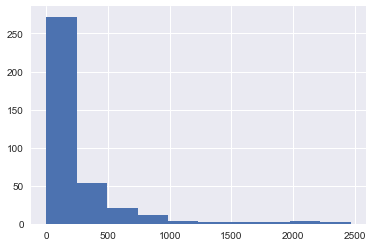

In [4]:
print len(ingListRaw)
ingFreqArr = Araw.T.dot(np.ones(nrow))
plt.hist(ingFreqArr)
# ids = np.argsort(ingFreqArr)[::-1]
# for j in ids[:10]:
#     print ingListRaw[j]
    
min_rec_cut = 10 # 3
max_rec_cut = 500 # 800
valid_ing_ids = (ingFreqArr>=min_rec_cut) & (ingFreqArr <= max_rec_cut)
A1 = Araw[:, valid_ing_ids]
print A1.shape
# plt.hist(ingFreqFilt, bins = np.linspace(1, 100, 30))

# remove extremely rare ingredients
ingList = []
for idx in range(len(ingListRaw)):
    if valid_ing_ids[idx] == 1:
        ingList.append(ingListRaw[idx])

# normalize each ingredient column to have mean = 0, std = 1
mean_ing = np.mean(A1, axis = 0)
std_ing = np.std(A1, axis = 0)
Anorm = (A1 - mean_ing)/std_ing
# Anormnmf = A1/ingFreqArr[valid_ing_ids]
Anormnmf = A1
print np.std(Anorm)
print np.mean(Anorm)

# Nonnegative Matrix Factorization (NMF)
## Dimensionality Reduction & Prototype Discovery

In [164]:
num_prototypes = 50
nmf = NMF(n_components=num_prototypes, init=None, solver='cd', tol=0.0001, max_iter=1000)
Wraw = nmf.fit_transform(Anormnmf)
Hraw = nmf.components_
print 'done'

done


In [167]:
H = (Hraw.T/np.sum(Hraw.T, axis = 0)).T
hDict = {}
num_words_per_proto = 8
for proto_idx in range(num_prototypes):
    hDict[proto_idx] = []
    h = H[proto_idx, :]
    ids = np.argsort(h)[::-1]
    for idx in ids[:num_words_per_proto]:
        hDict[proto_idx].append([ingList[idx], h[idx]])
#         print ingList[idx], h[idx]

Z = Anormnmf.dot(H[:num_prototypes, :].T)
print 'done'

done


In [187]:
print hDict[1]


[['seafood', 0.46093519287065032], ['scallop', 0.059480711067035535], ['clam', 0.05224795812081981], ['crab', 0.049410409523850236], ['mussel', 0.047327394859342134], ['lobster', 0.03308582241052823], ['chile pepper', 0.022002523740971437], ['bass', 0.021575621455608141]]


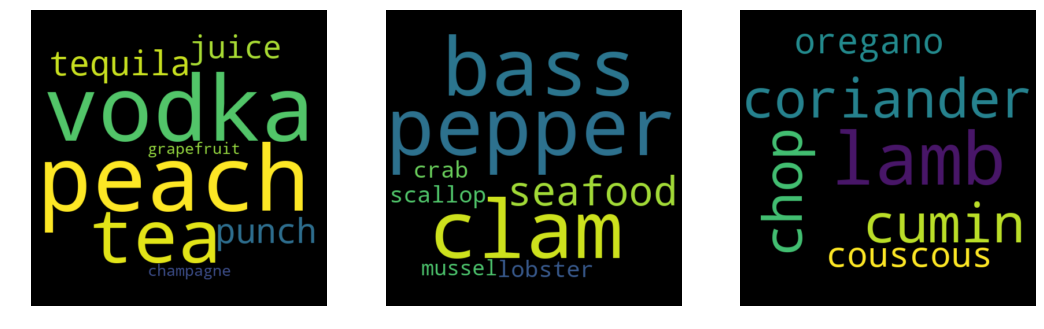

In [362]:
fig, ax = plt.subplots(1, 3, figsize = (18, 24))
for plt_ct, idx in enumerate([0, 1, 38]):
    text = ' '
    for ct, row in enumerate(hDict[idx][::-1]):
            raw_word = row[0]
            if ' ' in  raw_word:
                word = raw_word.split(' ')[1]
            else:
                word = raw_word
            text += word + ' '

    mask = np.array(Image.open('rounded.jpg'))
    wc = WordCloud(background_color="black", mask = mask)
    wc.generate(text)
    # wc.to_file('%s.png' % proto_name)
    ax[plt_ct].imshow(wc, interpolation='bilinear')
    ax[plt_ct].axis("off")


# Clustering

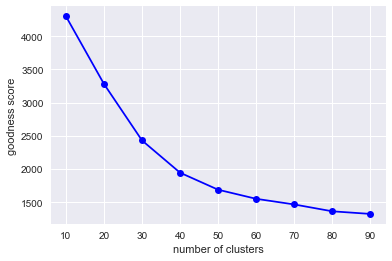

In [328]:
kList = np.arange(10, 100, 10)
lossList = []
for k in kList:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                           max_iter=5000, precompute_distances=True,)

    kmeans.fit(Z)
    lbls = kmeans.labels_
    loss = kmeans.inertia_
    lossList.append(loss)
plt.plot(kList, lossList, 'b-o')
plt.xlabel('number of clusters')
plt.ylabel('goodness score')

In [329]:
k = 25
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                           max_iter=1000, precompute_distances=True,)
kmeans.fit(Z)
lblArr = kmeans.labels_

dishNameList = [i[0] for i in rawDataList[1:]]
lblList = list(lblArr)
for i in range(k):
    print i, lblList.count(i)
print 'done'


0 12369
1 343
2 337
3 354
4 283
5 339
6 342
7 514
8 192
9 319
10 354
11 375
12 456
13 295
14 235
15 356
16 235
17 405
18 291
19 352
20 350
21 250
22 212
23 239
24 255
done


In [330]:
ct = 0
for i in range(nrow):
    if lblList[i] == 2 and ct < 20:
        print dishNameList[i]
        ct += 1

Spicy Noodle Soup 
Coconut-Key Lime Sheet Cake 
1977 Coconut Angel Food Cake 
Banana Split with Curried Chocolate-Coconut Sauce 
Florida Ambrosia Salad 
Savory Yogurt Cooler 
Grilled Curried Mangoes with Ginger Ice Milk 
Mixed Vegetables with Coconut Sauce (Aviyal) 
Pumpkin Flan with Meringue 
Chocolate Coconut Squares 
Coriander Chutney 
Vanilla Bean-Coconut Cupcakes with Coconut Frosting 
Toasted Coconut Macadamia Pound Cake 
Coconut Red-Lentil Curry 
Coconut Sauce 
Curry-Coconut Mussels Babalu's 
White Cake with Coconut, Pecan and Chocolate Chip Frosting 
Lemon and Toasted-Coconut Meringue Pie 
Coconut Chicken Soup 
Double and By Double I Mean Triple Chocolate Cookies 


12


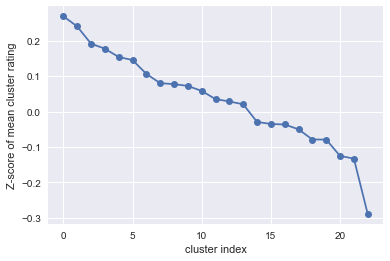

In [355]:
ans = list()
ratDict = {}
ratingsArrFilt = ratingsArr[ratingsArr > 1.0]
mean_rat = np.mean(ratingsArrFilt)
for i in range(k):
    ratArrRaw = ratingsArr[lblArr == i]
    ratArr = ratArrRaw[ratArrRaw > 1.0]
    ans.append([(np.mean(ratArr) - mean_rat)/np.std(ratingsArrFilt), len(ratArr), i])
    ratDict[i] = (ratArr - mean_rat)/np.std(ratingsArrFilt)
ans.sort(key = lambda x: x[0], reverse = True)
ansArr = np.array([i[0] for i in ans]) 
nArr = np.array([i[1] for i in ans])
idxArr = np.array([i[2] for i in ans])  
print idxArr[0]
plt.plot(ansArr, '-o')
plt.ylabel('Z-score of mean cluster rating')
plt.xlabel('cluster index')

(-1, 1)

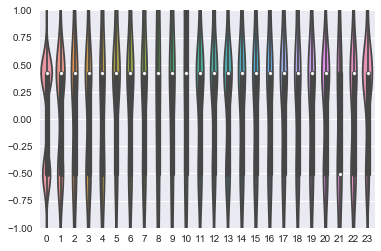

In [353]:
d = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ratDict.iteritems() ]))
sns.violinplot(d)
plt.ylim((-1, 1))